In [1]:
import numpy as np

# Define the log prior
def log_prior(theta):
    mu, sigma = theta
    if 0 < sigma < 10:  # Prior for sigma must be positive
        return 0.0  # Flat prior
    return -np.inf  # Reject invalid sigma values

# Define the log likelihood
def log_likelihood(theta, data):
    mu, sigma = theta
    return -0.5 * np.sum(((data - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

# Define the log posterior (log probability)
def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

In [2]:
import emcee

# Generate some mock data (Gaussian data with mean=0, stddev=1)
np.random.seed(42)
data = np.random.normal(0, 1, 100)

# Number of dimensions (mu and sigma)
ndim = 2

# Number of walkers (ensemble size) - typically 2-3 times the number of dimensions
nwalkers = 10

# Initial positions of the walkers (random guesses)
initial_guesses = np.random.randn(nwalkers, ndim)

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])

In [3]:
# Run the MCMC for 500 steps
nsteps = 500
sampler.run_mcmc(initial_guesses, nsteps, progress=True)

# Get the samples from the sampler chain
samples = sampler.get_chain()

  0%|          | 0/500 [00:00<?, ?it/s]/Users/simran/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:00<00:00, 3584.08it/s]


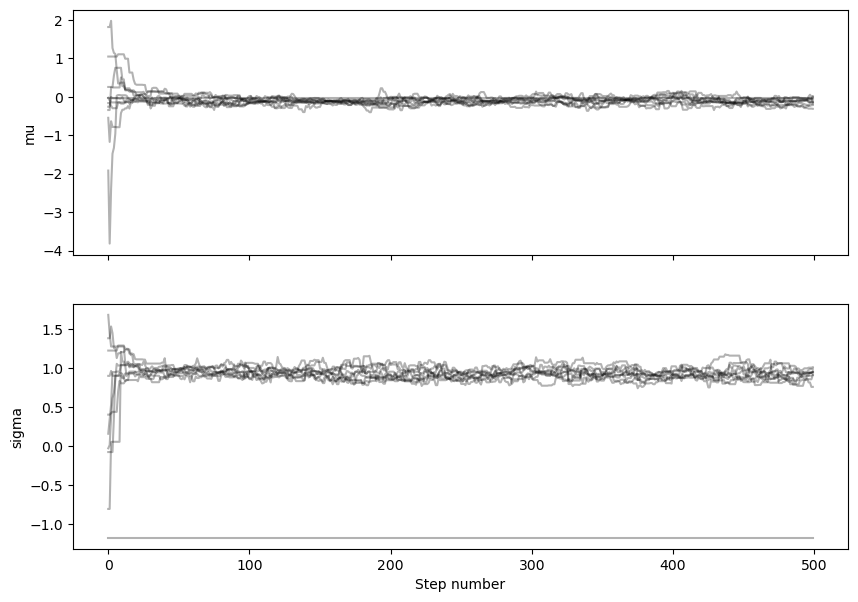

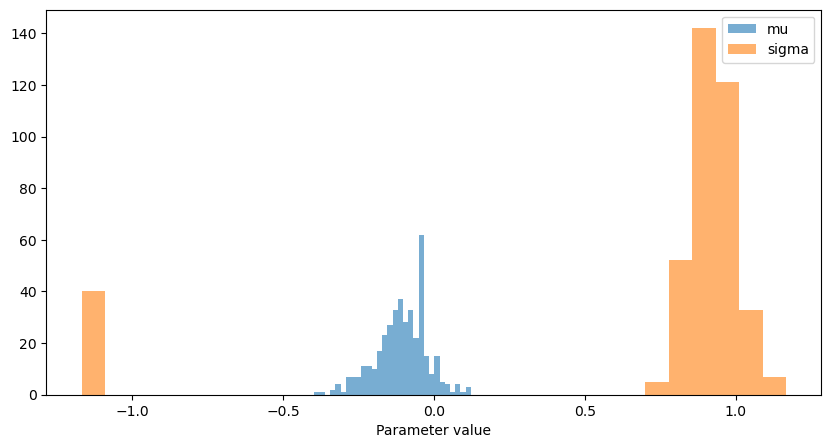

In [4]:
import matplotlib.pyplot as plt

# Plot the walker chains for each parameter
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ["mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()

# Flatten the chain (remove burn-in and combine walkers)
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot histograms of the posterior samples
plt.figure(figsize=(10,5))
plt.hist(flat_samples[:, 0], bins=30, alpha=0.6, label="mu")
plt.hist(flat_samples[:, 1], bins=30, alpha=0.6, label="sigma")
plt.xlabel("Parameter value")
plt.legend()
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_11750/4001524877.py:8: RuntimeWarning: divide by zero encountered in power
  rho_m = (omega_m * a ** (-3))
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_11750/4001524877.py:9: RuntimeWarning: divide by zero encountered in power
  rho_r = (omega_r * a ** (-4))


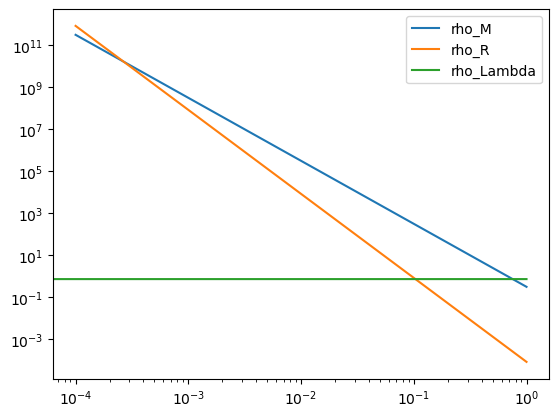

In [3]:
a = np.linspace(0, 1, 10000)
a0 = np.ones(10000)
omega_m = 0.3
omega_r = 8e-5
omega_k = 0
omega_l = 1 - omega_m - omega_r - omega_k
h0 = 0.7
rho_m = (omega_m * a ** (-3))
rho_r = (omega_r * a ** (-4))
rho_l = (omega_l * a0)

plt.xscale('log')
plt.yscale('log')


plt.plot(a, rho_m, label='rho_M')
plt.plot(a, rho_r, label='rho_R')
plt.plot(a, rho_l, label='rho_Lambda')
plt.legend()
plt.show()



In [4]:

for i in range(len(a)):
    if np.log10(rho_m[i]) == np.log10(rho_r[i]):
        a1 = i
    #if rho_m[i] == rho_l[i]:
        #a2 = i

print(a1)#, a2)
print('Radiation dominates at a <', np.log10(a[i]))
print('Matter dominates at a > ', np.log10(a[i]))
print('Dark energy dominates at a > ', a[i])


0
Radiation dominates at a < 0.0
Matter dominates at a >  0.0
Dark energy dominates at a >  1.0


Best-fit Omega_m: 0.5
Best-fit H0: 67.34693877551021


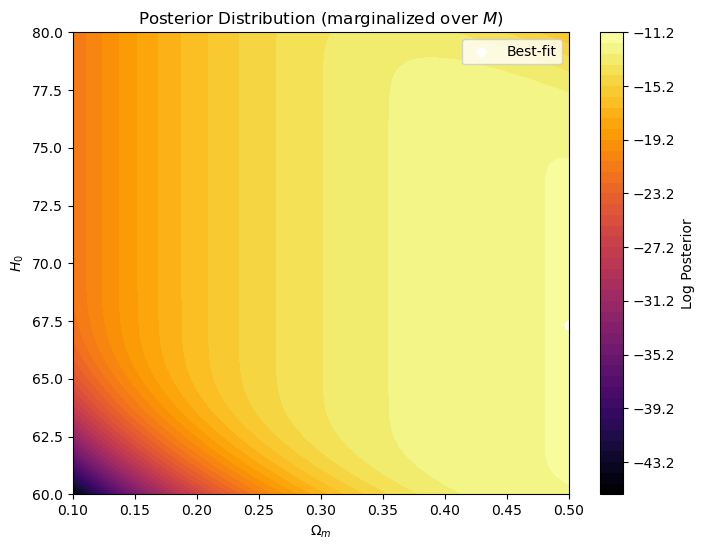

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Luminosity distance in a flat Lambda-CDM universe
def luminosity_distance(z, Omega_m, H0):
    """Calculate luminosity distance in Mpc for a flat universe."""
    c = 299792.458  # speed of light in km/s
    Omega_lambda = 1.0 - Omega_m
    integrand = lambda z: 1.0 / np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)
    integral = np.array([quad(integrand, 0, zi)[0] for zi in z])
    d_L = (1 + z) * integral * c / H0
    return d_L

# Distance modulus
def distance_modulus(z, Omega_m, H0):
    """Calculate the distance modulus."""
    d_L = luminosity_distance(z, Omega_m, H0)
    mu = 5 * np.log10(d_L) + 25
    return mu

# Likelihood function
def log_likelihood(Omega_m, H0, z, mu_obs, sigma_mu, M_grid):
    """Log-likelihood marginalized over M using grid sampling."""
    mu_model = distance_modulus(z, Omega_m, H0)
    
    likelihood = np.zeros(len(M_grid))
    for i, M in enumerate(M_grid):
        chi2 = np.sum(((mu_obs - mu_model - M) / sigma_mu)**2)
        likelihood[i] = np.exp(-0.5 * chi2)
    
    # Normalize likelihood over M and sum over grid
    marginal_likelihood = np.sum(likelihood) / len(M_grid)
    return np.log(marginal_likelihood)

# Define prior for M (Gaussian prior)
def prior_M(M, M_mean, M_sigma):
    """Gaussian prior on absolute magnitude M."""
    return np.exp(-0.5 * ((M - M_mean) / M_sigma)**2)

# Prior function for cosmological parameters
def log_prior(Omega_m, H0):
    if 0.0 < Omega_m < 1.0 and 50 < H0 < 100:  # Flat priors
        return 0.0
    return -np.inf

# Posterior function
def log_posterior(Omega_m, H0, z, mu_obs, sigma_mu, M_grid):
    """Posterior function marginalizing over M."""
    lp = log_prior(Omega_m, H0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(Omega_m, H0, z, mu_obs, sigma_mu, M_grid)

# Generate synthetic data
np.random.seed(42)
z_true = np.linspace(0.01, 1.0, 30)  # Redshifts
Omega_m_true = 0.3
H0_true = 70.0
M_true = -19.3
sigma_mu = 0.2  # Standard deviation of distance modulus

# Generate synthetic distance moduli
mu_true = distance_modulus(z_true, Omega_m_true, H0_true) + M_true
mu_obs = mu_true + np.random.normal(0, sigma_mu, size=mu_true.shape)

# Define grid for M (absolute magnitude)
M_grid = np.linspace(-19.6, -19.0, 100)

# Perform grid sampling over Omega_m and H0
Omega_m_values = np.linspace(0.1, 0.5, 50)
H0_values = np.linspace(60, 80, 50)

# Create a grid of likelihood values
log_posterior_grid = np.zeros((len(Omega_m_values), len(H0_values)))

for i, Omega_m in enumerate(Omega_m_values):
    for j, H0 in enumerate(H0_values):
        log_posterior_grid[i, j] = log_posterior(Omega_m, H0, z_true, mu_obs, sigma_mu, M_grid)

# Find the maximum of the posterior grid
max_indices = np.unravel_index(np.argmax(log_posterior_grid), log_posterior_grid.shape)
Omega_m_best = Omega_m_values[max_indices[0]]
H0_best = H0_values[max_indices[1]]

print(f"Best-fit Omega_m: {Omega_m_best}")
print(f"Best-fit H0: {H0_best}")

# Plot the posterior grid
plt.figure(figsize=(8, 6))
plt.contourf(Omega_m_values, H0_values, log_posterior_grid.T, levels=50, cmap='inferno')
plt.colorbar(label='Log Posterior')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$H_0$')
plt.title('Posterior Distribution (marginalized over $M$)')
plt.scatter(Omega_m_best, H0_best, color='white', label='Best-fit')
plt.legend()
plt.show()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_75285/3462037747.py:33: RuntimeWarning: divide by zero encountered in log
  return np.log(marginal_likelihood)


Best-fit Omega_m: 0.1


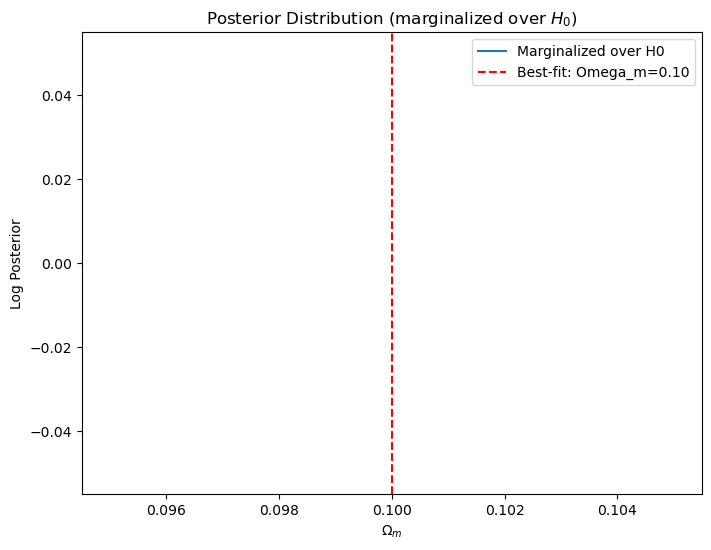

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Luminosity distance in a flat Lambda-CDM universe
def luminosity_distance(z, Omega_m, H0):
    """Calculate luminosity distance in Mpc for a flat universe."""
    c = 299792.458  # speed of light in km/s
    Omega_lambda = 1.0 - Omega_m
    integrand = lambda z: 1.0 / np.sqrt(Omega_m * (1 + z)**3 + Omega_lambda)
    integral = np.array([quad(integrand, 0, zi)[0] for zi in z])
    d_L = (1 + z) * integral * c / H0
    return d_L

# Distance modulus
def distance_modulus(z, Omega_m, H0):
    """Calculate the distance modulus."""
    d_L = luminosity_distance(z, Omega_m, H0)
    mu = 5 * np.log10(d_L) + 25
    return mu

# Likelihood function
def log_likelihood(Omega_m, z, mu_obs, sigma_mu, H0_grid):
    """Log-likelihood marginalized over H0 using grid sampling."""
    likelihood = np.zeros(len(H0_grid))
    for i, H0 in enumerate(H0_grid):
        mu_model = distance_modulus(z, Omega_m, H0)
        chi2 = np.sum(((mu_obs - mu_model) / sigma_mu)**2)
        likelihood[i] = np.exp(-0.5 * chi2)
    
    # Normalize likelihood over H0 and sum over grid
    marginal_likelihood = np.sum(likelihood) / len(H0_grid)
    return np.log(marginal_likelihood)

# Prior function for cosmological parameters
def log_prior(Omega_m):
    if 0.0 < Omega_m < 1.0:  # Flat prior on Omega_m
        return 0.0
    return -np.inf

# Posterior function
def log_posterior(Omega_m, z, mu_obs, sigma_mu, H0_grid):
    """Posterior function marginalizing over H0."""
    lp = log_prior(Omega_m)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(Omega_m, z, mu_obs, sigma_mu, H0_grid)

# Generate synthetic data
np.random.seed(42)
z_true = np.linspace(0.01, 1.0, 30)  # Redshifts
Omega_m_true = 0.3
H0_true = 70.0
M_true = -19.3
sigma_mu = 0.2  # Standard deviation of distance modulus

# Generate synthetic distance moduli
mu_true = distance_modulus(z_true, Omega_m_true, H0_true) + M_true
mu_obs = mu_true + np.random.normal(0, sigma_mu, size=mu_true.shape)

# Define grid for H0 (Hubble constant)
H0_grid = np.linspace(60, 80, 100)

# Perform grid sampling over Omega_m and marginalize over H0
Omega_m_values = np.linspace(0.1, 0.5, 50)

# Create a grid of likelihood values marginalized over H0
log_posterior_grid = np.zeros(len(Omega_m_values))

for i, Omega_m in enumerate(Omega_m_values):
    log_posterior_grid[i] = log_posterior(Omega_m, z_true, mu_obs, sigma_mu, H0_grid)

# Find the maximum of the posterior grid
Omega_m_best = Omega_m_values[np.argmax(log_posterior_grid)]

print(f"Best-fit Omega_m: {Omega_m_best}")

# Plot the posterior distribution
plt.figure(figsize=(8, 6))
plt.plot(Omega_m_values, log_posterior_grid, label='Marginalized over H0')
plt.axvline(Omega_m_best, color='red', linestyle='--', label=f'Best-fit: Omega_m={Omega_m_best:.2f}')
plt.xlabel(r'$\Omega_m$')
plt.ylabel('Log Posterior')
plt.title('Posterior Distribution (marginalized over $H_0$)')
plt.legend()
plt.show()

In [5]:
import numpy as np
from chainconsumer import ChainConsumer

# Example: Two MCMC chains with two parameters each (theta1, theta2)
np.random.seed(42)
# Simulate two different chains
chain_1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=10000)
chain_2 = np.random.multivariate_normal([1, 2], [[1, -0.5], [-0.5, 1]], size=10000)

# Create labels for the parameters
parameters = ["theta1", "theta2"]

# Create ChainConsumer instance
c = ChainConsumer()

# Add the first chain with a label
c.add_chain(chain_1, parameters=parameters, name="Chain 1", color="blue")

# Add the second chain with a different label and color
c.add_chain(chain_2, parameters=parameters, name="Chain 2", color="red")

# Customize the plot appearance (optional)
c.configure(statistics="max", legend=True)

# Generate the plot with confidence intervals (default 1- and 2-sigma contours)
fig = c.plotter.plot(figsize=(6, 6))

# If you want to save the plot, you can do so using matplotlib's savefig
fig.savefig("chain_comparison.png", dpi=300)

TypeError: ChainConsumer.add_chain() got an unexpected keyword argument 'parameters'

In [6]:
pip install numpy scipy matplotlib

python(57264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


Total GW detections: 146
Total EM detections: 0
Total Joint detections: 0


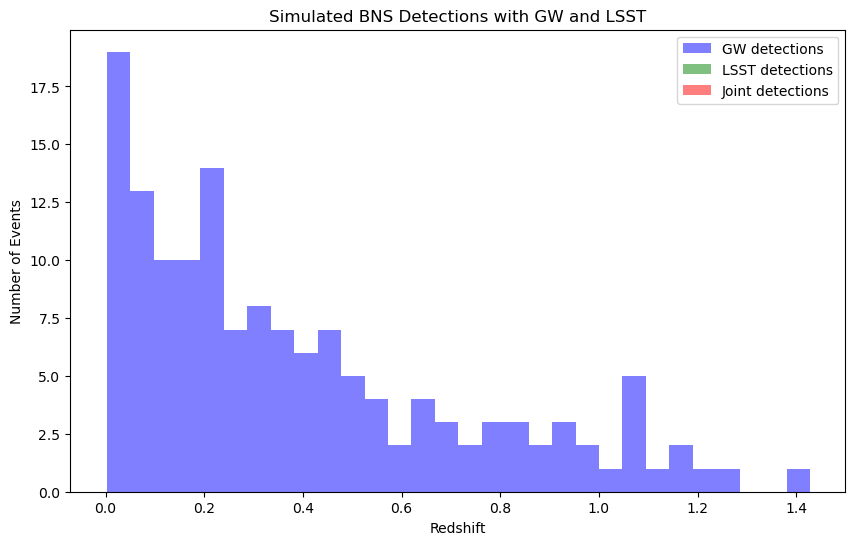

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Constants
H0_true = 70.0  # km/s/Mpc (true value of Hubble constant)
c = 299792.458  # Speed of light in km/s
z_max = 1.5  # Maximum redshift for LSST and GW detection
n_events = 1000  # Number of simulated BNS events

# Viewing angle dependency (angle relative to line of sight)
def viewing_angle_dependent_detection(theta):
    """Returns the viewing angle dependency for GW signal strength"""
    return np.cos(theta)**2  # Simplified model: face-on systems have stronger signals

# Redshift-luminosity distance relation
def luminosity_distance(z, H0):
    """Calculate luminosity distance in Mpc using the Hubble law (simple model)"""
    return (c / H0) * z

# Generate simulated redshifts for BNS events
def generate_redshifts(n_events, z_max):
    """Generates a list of redshifts for n_events, based on a uniform distribution"""
    return np.random.uniform(0, z_max, n_events)

# Malmquist bias for LIGO GW detections
def gw_detection_probability(luminosity_distance, max_distance=2000):
    """Calculate the detection probability based on distance and Malmquist bias for LIGO"""
    return np.exp(-luminosity_distance / max_distance)  # Detection drops with distance

# Malmquist bias for LSST EM detections (magnitude-limited survey)
def lsst_detection_probability(luminosity_distance, z, max_mag=24.5):
    """Returns detection probability based on LSST limiting magnitude"""
    m = 5 * np.log10(luminosity_distance * (1 + z)) + 25  # Apparent magnitude
    return stats.norm.cdf(max_mag - m)  # Detection probability based on magnitude cutoff

# Simulate a standard siren data set
def simulate_bns_data(n_events, H0_true, z_max):
    """Simulate BNS events with gravitational wave and electromagnetic counterparts"""
    # Generate redshifts
    redshifts = generate_redshifts(n_events, z_max)
    
    # Calculate luminosity distances for each redshift
    distances = luminosity_distance(redshifts, H0_true)

    # Viewing angles uniformly distributed between 0 and pi/2 (0 = face-on, pi/2 = edge-on)
    viewing_angles = np.random.uniform(0, np.pi / 2, n_events)

    # GW detection probabilities (based on distance and viewing angle)
    gw_detection_prob = gw_detection_probability(distances) * viewing_angle_dependent_detection(viewing_angles)
    
    # LSST EM detection probabilities (based on distance, redshift, and Malmquist bias)
    lsst_detection_prob = lsst_detection_probability(distances, redshifts)

    # Simulated detections (probabilistic)
    gw_detections = np.random.rand(n_events) < gw_detection_prob
    em_detections = np.random.rand(n_events) < lsst_detection_prob

    # Combine GW and EM detections
    joint_detections = gw_detections & em_detections

    # Return the simulated dataset
    return redshifts, distances, gw_detections, em_detections, joint_detections

# Plot results
def plot_results(redshifts, gw_detections, em_detections, joint_detections):
    """Plot detection results for GW and EM follow-up"""
    plt.figure(figsize=(10, 6))
    
    # Redshifts of detected events
    plt.hist(redshifts[gw_detections], bins=30, alpha=0.5, label='GW detections', color='b')
    plt.hist(redshifts[em_detections], bins=30, alpha=0.5, label='LSST detections', color='g')
    plt.hist(redshifts[joint_detections], bins=30, alpha=0.5, label='Joint detections', color='r')
    
    plt.xlabel('Redshift')
    plt.ylabel('Number of Events')
    plt.legend()
    plt.title('Simulated BNS Detections with GW and LSST')
    plt.show()

# Main function to run the simulation and plot
def main():
    redshifts, distances, gw_detections, em_detections, joint_detections = simulate_bns_data(
        n_events, H0_true, z_max)
    
    print(f"Total GW detections: {np.sum(gw_detections)}")
    print(f"Total EM detections: {np.sum(em_detections)}")
    print(f"Total Joint detections: {np.sum(joint_detections)}")
    
    # Plot detection results
    plot_results(redshifts, gw_detections, em_detections, joint_detections)

# Run the simulation
if __name__ == "__main__":
    main()